In [1]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
from torchsummary import summary
import model

In [2]:
def get_distribution(load_path):
    softmax = torch.nn.Softmax(dim=0)
    checkpoint = torch.load(load_path)
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    
    mean_scale_list = []
    var_scale_list = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        
        scaling_factor = re.search(pattern_scaling_factor, key)
        
        if bn_3:
            values = weights[key]
            mean_scale_list[-1][1] = torch.mean(values).cpu()
            var_scale_list[-1][1] = torch.var(values).cpu()
        if bn_7:
            values = weights[key]
            mean_scale_list[-1][2] = torch.mean(values).cpu()
            var_scale_list[-1][2] = torch.var(values).cpu()

        if scaling_factor:
            value = weights[key]
            value = softmax(value)
            mean_scale_list.append([value[0].cpu(),0,0])
            var_scale_list.append([value[0].cpu(),0,0])
    return mean_scale_list, var_scale_list

In [3]:
def plot_distribution(load_path, save_path):
    mean_scale_list, var_scale_list = get_distribution(load_path)
    x = [elem[0] for elem in mean_scale_list]
    y1 = [elem[1] for elem in mean_scale_list]
    y2 = [elem[2] for elem in mean_scale_list]
    y3 = [elem[1] for elem in var_scale_list]
    y4 = [elem[2] for elem in var_scale_list]
    
    #print(x)
    #print(y1)
    #print(y2)
    coeff1 = np.corrcoef(x, y1)
    coeff2 = np.corrcoef(x, y2)
    #coeff3 = np.corrcoef(y1, y2)
    
    print("Korrelationskoeffizient scaling factor - Durschnitt bn layer 1: " + str(coeff1[0][1]))
    print("Korrelationskoeffizient scaling factor - Durschnitt bn layer 2: " + str(coeff2[0][1]))
    #print(coeff3)
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel('block scaling factor')
    ax.set_ylabel('mean channel scaling factor')
    ax.scatter(x,y1)
    ax.scatter(x,y2, marker="x")
    #ax.scatter(x,y3, marker="<")
    #ax.scatter(x,y4, marker=">")
    ax.legend(["Conv Layer 1 mean", "Conv Layer 2 mean", "Conv Layer 1 var", "Conv Layer 2 var"])
    plt.savefig(save_path)

In [4]:
def plot_distribution_layer_wise(load_path, save_path):
    mean_scale_list, var_scale_list = get_distribution(load_path)
    x = [range(0, len(mean_scale_list))]
    y0 = [elem[0] for elem in mean_scale_list]
    y1 = [elem[1] for elem in mean_scale_list]
    y2 = [elem[2] for elem in mean_scale_list]
    y3 = [elem[1] for elem in var_scale_list]
    y4 = [elem[2] for elem in var_scale_list]
    
    coeff0 = np.corrcoef(x, y0)
    coeff1 = np.corrcoef(x, y1)
    coeff2 = np.corrcoef(x, y2)
    #coeff3 = np.corrcoef(y1, y2)
    
    print("Korrelationskoeffizient layer - block scaling factor: " + str(coeff0[0][1]))
    print("Korrelationskoeffizient layer - Durschnitt bn layer 1: " + str(coeff1[0][1]))
    print("Korrelationskoeffizient layer - Durschnitt bn layer 2: " + str(coeff2[0][1]))
    
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlabel('Layer')
    ax.set_ylabel('Factor')
    ax.scatter(x, y0)
    ax.scatter(x,y1)
    ax.scatter(x,y2, marker="x")
    ax.legend(["Block Scaling Factor", "Conv Layer 1 mean", "Conv Layer 2 mean", "Conv Layer 1 var", "Conv Layer 2 var"])
    plt.savefig(save_path)

In [5]:
def plot_train_phase(load_path, save_name=""):
    checkpoint = torch.load(load_path)
    test_acc = np.array(checkpoint['test_acc_list'])
    train_acc = np.array(checkpoint['train_acc_list'])
    test_loss = np.array(checkpoint['test_loss_list'])
    train_loss = np.array(checkpoint['train_loss_list'])
    x = np.array(list(range(0, len(test_acc))))

    print(np.max(test_acc))
    fig, ax1 = plt.subplots()
    
    plt.grid(axis='both')
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    if len(train_acc) == len(x):
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x, train_acc, color='r')
    else:
        ax1.plot(x, test_acc, color='g')
        ax1.plot(x[1:], train_acc, color='r')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('loss')  # we already handled the x-label with ax1
    if len(train_loss) == len(x):
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, train_loss, color='y')
    else:
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x[1:], train_loss, color='y')
    ax2.tick_params(axis='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    ax2.legend(['test loss', 'train loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_name:
        plt.savefig(save_name)
    #plt.show()


In [6]:
def plot_train_phase_new(load_path, save_name=""):
    checkpoint = torch.load(load_path)
    test_acc = np.array(checkpoint['test_acc_list'])
    train_acc = np.array(checkpoint['train_acc_list'])
    test_loss_subdivision = np.array(checkpoint['test_loss_list'])
    train_loss_subdivision = np.array(checkpoint['train_loss_list'])    
    
    test_loss = [x[0] for x in test_loss_subdivision]
    test_loss_block = [x[1] for x in test_loss_subdivision]
    test_loss_channel = [x[2] for x in test_loss_subdivision]
    test_loss_acc = [x[3] for x in test_loss_subdivision]
    
    train_loss = [x[0] for x in train_loss_subdivision]
    train_loss_block = [x[1] for x in train_loss_subdivision]
    train_loss_channel = [x[2] for x in train_loss_subdivision]
    train_loss_acc = [x[3] for x in train_loss_subdivision]
    
    
    x = np.array(list(range(0, len(test_acc))))

    print(np.max(test_acc))
    fig, ax1 = plt.subplots()
    
    plt.grid(axis='both')
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    if len(train_acc) == len(x):
        ax1.plot(x, test_acc, color='g')
        #ax1.plot(x, train_acc, color='r')
    else:
        ax1.plot(x, test_acc, color='g')
        #ax1.plot(x[1:], train_acc, color='r')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('loss')  # we already handled the x-label with ax1
    if len(train_loss) == len(x):
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, train_loss, color='y')
    else:
        ax2.plot(x, test_loss, color='b')
        ax2.plot(x, test_loss_block, color='k')
        ax2.plot(x, test_loss_channel, color='m')
        ax2.plot(x, test_loss_acc, color='c')
        #ax2.plot(x[1:], train_loss, color='y')
    ax2.tick_params(axis='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    ax2.legend(['test loss', 'test loss block','test loss channel','test loss acc','train loss'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    if save_name:
        plt.savefig(save_name)
    #plt.show()


In [7]:
def count_parameters(model_state_dict):
    sum_elem = 0
    for key, item in model_state_dict.items():
        sum_elem += torch.numel(item)
    return sum_elem

In [8]:
def get_scaling_factor_distribution(load_path):
    softmax = torch.nn.Softmax(dim=0)
    print(load_path)
    checkpoint = torch.load(load_path)
    
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    
    scale_factor_list = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        
        scaling_factor = re.search(pattern_scaling_factor, key)
        
        if bn_3:
            values = weights[key]
            scale_factor_list[-1][1] = values
        if bn_7:
            values = weights[key]
            scale_factor_list[-1][2] = values

        if scaling_factor:
            value = weights[key]
            value = softmax(value)
            scale_factor_list.append([value[0].cpu(),0,0])
    return scale_factor_list

In [43]:
def plot_hist(load_path, save_name="", resolution=50, show=True):
    checkpoint = torch.load(load_path)
    weights = checkpoint['model_state_dict']
    pattern_scaling_factor = "module\.classifier\.[0-9]+\.classifier\.[1-9]+\.W"
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_ds_1 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifierPath\.1+\.weight"
    pattern_ds_4 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifierPath\.4+\.weight" 
    pattern_ds_0 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.batchnorm\.0+\.weight"
    values = []
    scaling_factor = []
    for key, item in weights.items():
        if re.search(pattern_scaling_factor, key):
            #print(item)
            scaling_factor += [item.item()]
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        ds_0 = re.search(pattern_ds_0, key)
        ds_1 = re.search(pattern_ds_1, key)
        ds_4 = re.search(pattern_ds_4, key)

        if bn_3 or bn_7 or ds_1 or ds_4 or ds_0:
            values += torch.squeeze(item).cpu().tolist()
    values = np.array(values)
    scaling_factor = np.array(scaling_factor)
    #print(len(list(filter(lambda i: i < 0.05, values))))
    print("Mean:" + str(round(np.mean(values), 3)).replace('.', ','))
    print("Variance: " + str(round(np.var(scaling_factor), 6)).replace('.', ','))
    #print(values)
    plt.hist(values, resolution)
    plt.grid()
    if save_name != "":
        plt.savefig(save_name)
    if show:
        plt.show()

Mean:0,547
Variance: 0,008695


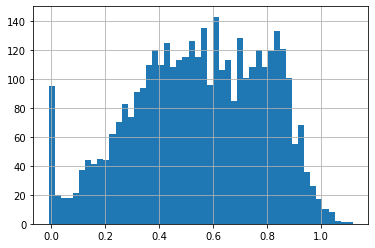

In [44]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/seed_10/delta03_gamma03/birdnet_v15.pt")

Mean:0,283
Variance: 0,000361


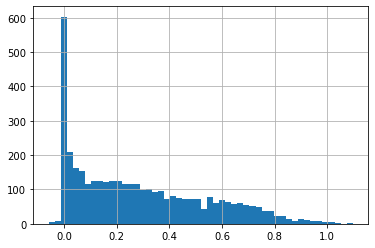

In [64]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/seed_30/delta07_gamma07/birdnet_v8.pt")

Mean:0,985
Variance: 0,003803


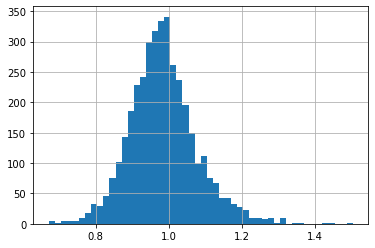

In [65]:
plot_hist("/media/eddy/Backup/models/CentEuro/network_size/seed_10/size_2/birdnet_v13.pt")

Mean:0,987
Variance: 0,004501


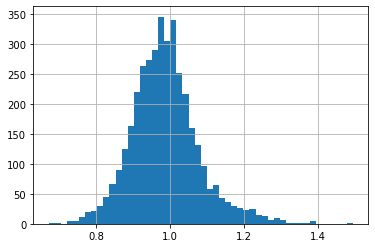

In [66]:
plot_hist("/media/eddy/Backup/models/CentEuro/network_size/seed_20/size_2/birdnet_v13.pt")

Mean:0,986
Variance: 0,006911


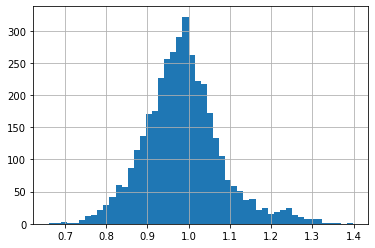

In [67]:
plot_hist("/media/eddy/Backup/models/CentEuro/network_size/seed_30/size_2/birdnet_v15.pt")

In [10]:
def model_summary(path, input_dim=(1,64,384)):
    checkpoint = torch.load(path)
    filters = checkpoint['filters']
    birdnet = model.BirdNet(filters=filters)
    birdnet = torch.nn.DataParallel(birdnet).cuda()
    summary(birdnet, input_dim)

Train Phase of Modell with gamma=0.5, delta=0.5 in together modus

In [11]:
def plot_accuracy_and_model_size_for_pruned_batch(path, path_baseline, epoch, channel_or_block="channel"):
    folders = os.listdir(path)
    folders = sorted(folders)
    folders = filter(lambda elem: os.path.isdir(path + elem + "/"),folders)
    files = []
    test_acc = []
    train_acc = []
    test_loss = []
    train_loss = []
    size = []
    baseline = torch.load(path_baseline)
    baseline_acc = baseline['test_acc_list'][-1]
    baseline_size = count_parameters(baseline['model_state_dict'])
    size.append(baseline_size)
    
    x = []
    x.append(0)
    for elem in folders:
        if channel_or_block == "channel":
            pattern = re.compile("c[0-9]+")
        else: 
            pattern = re.compile("b[0-9]+")
        result = pattern.search(elem)
        x.append(int(result[0][1:]))
        files.append(path + elem + "/birdnet_final.pt")
    
    print(x)
        
    for file in files: 
        checkpoint = torch.load(file)
        test_acc.append(np.array(checkpoint['test_acc_list']))
        train_acc.append(np.array(checkpoint['train_acc_list']))
        test_loss.append(np.array(checkpoint['test_loss_list']))
        train_loss.append(np.array(checkpoint['train_loss_list']))
        size.append(count_parameters(checkpoint['model_state_dict']))
    
    y = []
    
    y.append(baseline_acc)
    for elem in test_acc:
        if epoch < len(elem):
            y.append(elem[epoch])
        else: 
            y.append(elem[-1])
    print(y)
    print(size)
    #x = [i for i in range(0, 110, 10)]
    fig, ax1 = plt.subplots()
    plt.title(f'Test accuracy of pruned models after {epoch} epoch(s)')
    
    plt.grid(axis='both')
    ax1.set_xlabel('prune ratio')
    ax1.set_ylabel('accuracy')
    
    ax1.plot(x, y, color='g')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('num parameters')  # we already handled the x-label with ax1
    ax2.plot(x, size, color='b')
    ax1.legend(['accuracy'], loc='lower left')
    ax2.legend(['parameters'], loc='upper right')
    #plt.xticks(list(range(0, len(x), 2)))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(path + f"acc_model_size_epoch_{epoch}")

Resstack 1: Resblock 1:  154240 Param  
Resstack 1: Resblock 2:  205568 Param  
Resstack 1: Resblock 3:  205568 Param  
Resstack 2: Resblock 1:  222464 Param  
Resstack 2: Resblock 2:  296448 Param  
Resstack 2: Resblock 3:  296448 Param  
Resstack 3: Resblock 1:  939937 Param  
Resstack 3: Resblock 2: 1245729 Param  
Resstack 3: Resblock 3: 1245729 Param  
Resstack 4: Resblock 1: 3544064 Param  
Resstack 4: Resblock 2: 4724736 Param  
Resstack 4: Resblock 3: 4724736 Param  
Sum: 17805667  
DS Block 1:   4480  
DS Block 2:  17664  
DS Block 3:  70144  
DS Block 4: 279552  
ClassificationPath: 10794496  

Total: 28,789,491

In [12]:
def plot_train_process_for_all(path):
    elements = os.listdir(path)
    folders = filter(lambda elem: os.path.isdir(path + elem + "/"), elements)
    for folder in folders:
        plot_train_process_for_all(path + folder + "/")
    if "birdnet_final.pt" in elements:
        #plot_hist(path + "birdnet_final.pt", path + "hist")
        #plot_train_phase(path + "birdnet_final.pt", path + "train_phase")
        plot_distribution_layer_wise(path + "birdnet_final.pt", path + "dist_layer_wise")

In [13]:
def print_conv_layer_scaling_factors(name):
    checkpoint = torch.load(name)
    birdnet = model.BirdNet(filters=checkpoint['filters'])
    birdnet = torch.nn.DataParallel(birdnet).cuda()
    birdnet = birdnet.float()
    birdnet.load_state_dict(checkpoint['model_state_dict'])

    resblocks = []
    ds_blocks = []
    for resstack in birdnet.module.classifier:
        if isinstance(resstack, model.ResStack):
            for resblock in resstack.classifier:
                if isinstance(resblock, model.Resblock): 
                    resblocks.append(resblock.W.item())
                if isinstance(resblock, model.DownsamplingResBlock): 
                    ds_blocks.append(resblock.W.item())
    zeros1 = [1,2,3,4,5,6,7,8,9,10,11,12]
    zeros2 = [0,0,0,0]
    fig=plt.figure()     
    
    
    resblocks = np.array(resblocks)
    ds_blocks = np.array(ds_blocks)
    
    print("Resblock variance:" + str(np.var(resblocks)))
    print("DSBlock variance:" + str(np.var(ds_blocks)))
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(zeros1, resblocks, color='r')
    ax.scatter(zeros2, ds_blocks, color='b')
    ax.set_xlabel('Grades Range')
    ax.set_ylabel('Grades Scored')
    ax.set_title('scatter plot')
    plt.grid()
    plt.show()

In [16]:
plot_hist("/media/eddy/datasets/models/CentEuro/network_size/seed_20/size_2/birdnet_v13.pt")

TypeError: 'float' object is not iterable

3840
659
Mean:0.3097513540254837
Variance: 0.05931886214582403
[0.90124458 0.89945322 0.970882   ... 0.17480481 0.34066623 0.44318891]


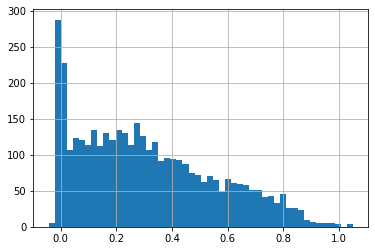

In [16]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/delta05_gamma03/birdnet_v14.pt")

3840
2777
Mean:0.08750174869800195
Variance: 0.031815306265454
[ 9.09891546e-01  9.45469618e-01  8.57655644e-01 ... -5.94026269e-03
 -1.45876009e-04  1.28308469e-02]


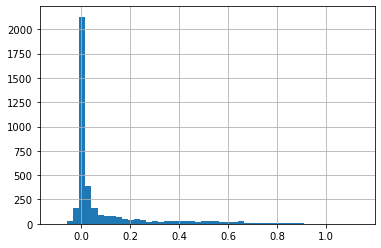

In [17]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/delta07_gamma03/birdnet_v17.pt")

3840
945
Mean:0.22662709306371476
Variance: 0.04359584866859524
[0.84255809 0.85066992 0.93285453 ... 0.13884373 0.21753627 0.47096652]


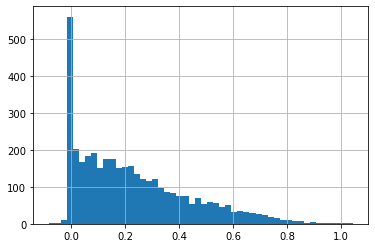

In [18]:
plot_hist("/media/eddy/datasets/models/CentEuro/baseline/sparsity/seed_10/birdnet_v22.pt")

In [19]:
checkpoint = torch.load("/media/eddy/datasets/models/CentEuro/network_size/seed_20/size_2/birdnet_v13.pt")

In [20]:
checkpoint['test_acc_list']

[0.01907032181168057,
 0.07389749702026222,
 0.14421930870083433,
 0.18831942789034564,
 0.24791418355184744,
 0.2789034564958284,
 0.20858164481525626,
 0.3218116805721097,
 0.39809296781883197,
 0.4171632896305125,
 0.45887961859356374,
 0.43146603098927294,
 0.45887961859356374,
 0.5196662693682956,
 0.4696066746126341,
 0.5601907032181168,
 0.5983313468414779,
 0.6066746126340882,
 0.5887961859356377,
 0.5983313468414779,
 0.6257449344457687]

0.7210965435041716


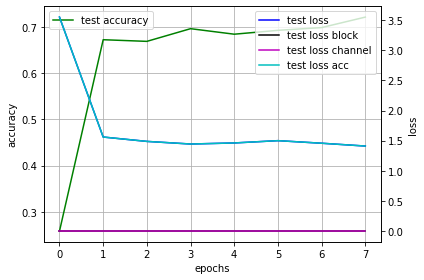

In [22]:
plot_train_phase_new("/media/eddy/datasets/models/CentEuro/pruned/seed_10/pruned_c30_b0_CURL_temp0.0_modeALL/birdnet_v3.pt")

In [54]:
def print_val_error_avg(load_path, save_name=""):
    checkpoints = []
    for elem in load_path:
        checkpoints.append(torch.load(elem))
    val_errors = []
    for checkpoint in checkpoints:
        val_errors.append(np.array(checkpoint['test_acc_list'][:40]))
    result = np.round(100*np.mean(val_errors, axis=0), 2)
    
    epochs = list(range(0, 100))
    zipped = zip(epochs, result)
    output = ""
    for elem in zipped:
        output += f"({elem[0]}, {elem[1]}) "
    print(output)
    

In [67]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/sparsity/seed_10/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/sparsity/seed_20/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/sparsity/seed_30/birdnet_final.pt"])

(0, 0.34) (1, 34.97) (2, 46.48) (3, 55.26) (4, 59.28) (5, 61.17) (6, 66.0) (7, 67.72) (8, 70.5) (9, 72.55) (10, 73.28) (11, 74.9) (12, 76.12) (13, 76.19) (14, 76.98) (15, 77.17) (16, 77.61) (17, 77.82) (18, 77.95) (19, 78.41) (20, 76.88) (21, 78.58) (22, 78.64) (23, 78.85) (24, 79.24) (25, 79.7) (26, 79.96) (27, 78.88) (28, 79.38) (29, 79.92) (30, 80.0) (31, 79.64) (32, 79.78) (33, 79.91) (34, 80.03) (35, 79.77) (36, 79.89) (37, 80.66) (38, 79.59) (39, 80.66) 


In [58]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c30_b0_MIN_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c30_b0_MIN_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c30_b0_MIN_temp0.0_modeALL/birdnet_final.pt"])

(0, 0.25) (1, 38.58) (2, 52.12) (3, 60.74) (4, 65.85) (5, 67.88) 


In [59]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c30_b0_EVENLY_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c30_b0_EVENLY_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c30_b0_EVENLY_temp0.0_modeALL/birdnet_final.pt"])

(0, 0.25) (1, 48.44) (2, 61.89) (3, 67.15) (4, 71.05) (5, 73.05) 


In [60]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c30_b0_NO_PADD_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c30_b0_NO_PADD_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c30_b0_NO_PADD_temp0.0_modeALL/birdnet_final.pt"])

(0, 78.36) (1, 80.8) (2, 79.53) (3, 81.09) (4, 81.14) (5, 81.05) 


In [68]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c30_b0_CURL_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c30_b0_CURL_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c30_b0_CURL_temp0.0_modeALL/birdnet_final.pt"])

(0, 24.6) (1, 78.94) (2, 78.96) (3, 79.57) (4, 79.18) (5, 80.22) 


In [65]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c50_b0_CURL_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c50_b0_CURL_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c50_b0_CURL_temp0.0_modeALL/birdnet_final.pt"])

(0, 5.94) (1, 73.94) (2, 76.08) (3, 76.69) (4, 77.27) (5, 78.04) 


In [69]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c50_b0_CURL_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c50_b0_CURL_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c50_b0_CURL_temp0.0_modeALL/birdnet_final.pt"])

(0, 5.94) (1, 73.94) (2, 76.08) (3, 76.69) (4, 77.27) (5, 78.04) 


In [70]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c50_b0_MIN_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c50_b0_MIN_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c50_b0_MIN_temp0.0_modeALL/birdnet_final.pt"])

(0, 0.99) (1, 19.29) (2, 31.41) (3, 37.03) (4, 45.8) (5, 50.24) 


In [71]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c50_b0_EVENLY_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c50_b0_EVENLY_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c50_b0_EVENLY_temp0.0_modeALL/birdnet_final.pt"])

(0, 1.92) (1, 37.14) (2, 51.45) (3, 58.75) (4, 62.98) (5, 66.77) 


In [72]:
print_val_error_avg(["/media/eddy/datasets/models/BirdCLEF/pruned/seed_10/pruned_c50_b0_NO_PADD_temp0.0_modeALL/birdnet_final.pt", 
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_20/pruned_c50_b0_NO_PADD_temp0.0_modeALL/birdnet_final.pt",
                     "/media/eddy/datasets/models/BirdCLEF/pruned/seed_30/pruned_c50_b0_NO_PADD_temp0.0_modeALL/birdnet_final.pt"])

(0, 65.28) (1, 80.6) (2, 80.85) (3, 80.8) (4, 80.7) (5, 81.09) 


In [52]:
checkpoint = torch.load("/media/eddy/datasets/models/CentEuro/baseline/sparsity/seed_30/birdnet_final.pt")
print(checkpoint['test_acc_list'])


[0.01907032181168057, 0.09535160905840286, 0.2061978545887962, 0.17044100119189512, 0.23361144219308702, 0.2789034564958284, 0.3170441001191895, 0.3230035756853397, 0.42550655542312277, 0.41477949940405245, 0.48510131108462456, 0.33492252681764006, 0.4696066746126341, 0.5494636471990465, 0.5625744934445769, 0.5506555423122765, 0.5971394517282479, 0.5721096543504172, 0.6436233611442194, 0.6257449344457687, 0.6460071513706794, 0.6448152562574494, 0.6626936829558999, 0.6555423122765197, 0.6841477949940405, 0.6400476758045291, 0.6698450536352801, 0.6912991656734208, 0.6972586412395709, 0.6686531585220501, 0.6483909415971395, 0.6901072705601907, 0.6817640047675805, 0.6972586412395709, 0.698450536352801, 0.6817640047675805, 0.6769964243146603, 0.6698450536352801, 0.6924910607866508, 0.6972586412395709, 0.6698450536352801, 0.6841477949940405, 0.7258641239570918, 0.6710369487485102, 0.699642431466031, 0.7151370679380215, 0.6281287246722288, 0.700834326579261, 0.6769964243146603, 0.696066746126

In [89]:
def plot_flops():
    x = [0.7, 0.725, 0.75, 0.775, 0.8]
    y = [420727289, 367566449, 333339161, 277577633, 234779609]
    

    fig, ax1 = plt.subplots()
    
    plt.grid(axis='both')
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('accuracy')
    ax1.plot(x, y, color='g')
    ax1.tick_params(axis='y')


    color = 'tab:blue'
        #ax2.plot(x[1:], train_loss, color='y')

    #plt.xticks(list(range(0, len(x), 2)))
    ax1.legend(['test accuracy', 'train accuracy'])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #plt.show()


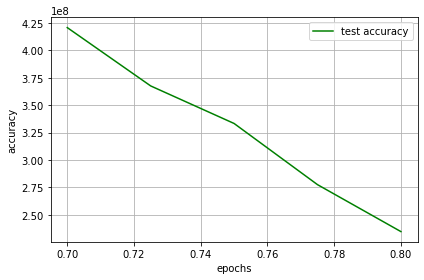

In [90]:
plot_flops()

Mean:0,558006778201184
Variance: 0,05850307185058617


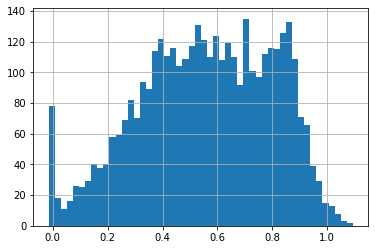

In [18]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/seed_10/delta03_gamma03/birdnet_v14.pt")

Mean:0,6731561678490834
Variance: 0,028338681474182618


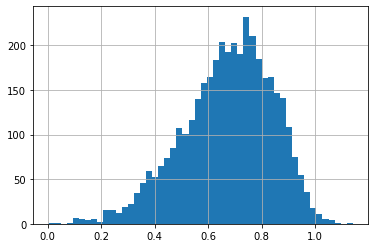

In [19]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/seed_20/delta03_gamma03/birdnet_v14.pt")

Mean:0,3528143039587084
Variance: 0,06973572312210764


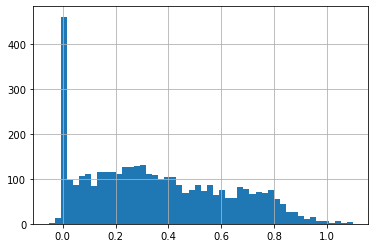

In [36]:
plot_hist("/media/eddy/datasets/models/CentEuro/hyperparameters/seed_30/delta07_gamma07/birdnet_v6.pt")

In [ ]:
def plot_var(load_paths, save_name="", resolution=50, show=True):
    checkpoint = torch.load(load_path)
    weights = checkpoint['model_state_dict']
    pattern_bn_3 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.3+\.weight"
    pattern_bn_7 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifier\.7+\.weight"
    pattern_ds_1 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifierPath\.1+\.weight"
    pattern_ds_4 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.classifierPath\.4+\.weight" 
    pattern_ds_0 = "module\.classifier\.[0-9]+\.classifier\.[0-9]+\.batchnorm\.0+\.weight"
    values = []
    
    for key, item in weights.items():
        bn_3 = re.search(pattern_bn_3, key)
        bn_7 = re.search(pattern_bn_7, key)
        ds_0 = re.search(pattern_ds_0, key)
        ds_1 = re.search(pattern_ds_1, key)
        ds_4 = re.search(pattern_ds_4, key)

        if bn_3 or bn_7 or ds_1 or ds_4 or ds_0:
            values += torch.squeeze(item).cpu().tolist()
    values = np.array(values)
    #print(len(values))
    #print(len(list(filter(lambda i: i < 0.05, values))))
    print("Mean:" + str(np.mean(values)).replace('.', ','))
    print("Variance: " + str(np.var(values)).replace('.', ','))
    #print(values)
    plt.hist(values, resolution)
    plt.grid()
    if save_name != "":
        plt.savefig(save_name)
    if show:
        plt.show()